# 0.0 IMPORTS

In [127]:
import pandas as pd
import inflection
import regex as re
import plotly.express as px
import folium
from haversine import haversine

## 0.1 Helper Functions

## 0.2 Loading Data

In [39]:
df = pd.read_csv('../repos/train.csv')
df.columns

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weatherconditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)'],
      dtype='object')

# 1.0 DATA DESCRIPTIONS

In [40]:
df1 = df.copy()

## 1.1. Rename Columns


In [41]:
cols_old = ['ID', 'Delivery_person_ID', 'Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude',
            'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
            'Time_Order_picked', 'Weatherconditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
            'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Data Dimensions


In [42]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 45593
Número de colunas: 20


## 1.3. Data Types


In [43]:
df1.dtypes


id                              object
delivery_person_id              object
delivery_person_age             object
delivery_person_ratings         object
restaurant_latitude            float64
restaurant_longitude           float64
delivery_location_latitude     float64
delivery_location_longitude    float64
order_date                      object
time_orderd                     object
time_order_picked               object
weatherconditions               object
road_traffic_density            object
vehicle_condition                int64
type_of_order                   object
type_of_vehicle                 object
multiple_deliveries             object
festival                        object
city                            object
time_taken(min)                 object
dtype: object

## 1.4. Fillout NA


In [44]:
# Tirar linhas com Nan
linhas_selecionadas = (df1['delivery_person_age'] != 'NaN ')
df1 = df1.loc[linhas_selecionadas, :].copy()

linhas_selecionadas = (df1['road_traffic_density'] != 'NaN ')
df1 = df1.loc[linhas_selecionadas, :].copy()

linhas_selecionadas = (df1['time_taken(min)'] != 'NaN ')
df1 = df1.loc[linhas_selecionadas, :].copy()

linhas_selecionadas = (df1['festival'] != 'NaN ')
df1 = df1.loc[linhas_selecionadas, :].copy()

linhas_selecionadas = (df1['city'] != 'NaN ')
df1 = df1.loc[linhas_selecionadas, :].copy()

## 1.5. Change Types


In [45]:
# Converter a coluna age para int
df1['delivery_person_age'] = df1['delivery_person_age'].astype('int64')

# converter a coluna ratings de texto para número decimal (float)
df1['delivery_person_ratings'] = df1['delivery_person_ratings'].astype(float)

# converter a order_date de texto para data
df1['order_date'] = pd.to_datetime(df1['order_date'], format='%d-%m-%Y')

# converter multiple_deliveries de texto para numero inteiro (int)
linhas_selecionadas = (df1['multiple_deliveries'] != 'NaN ')
df1 = df1.loc[linhas_selecionadas, :].copy()
df1['multiple_deliveries'] = df1['multiple_deliveries'].astype('int64')

# Remover o texto de números
df1.loc[:, "id"] = df1.loc[:, "id"].str.strip()
df1.loc[:, "road_traffic_density"] = df1.loc[:, "road_traffic_density"].str.strip()
df1.loc[:, "type_of_order"] = df1.loc[:, "type_of_order"].str.strip()
df1.loc[:, "type_of_vehicle"] = df1.loc[:, "type_of_vehicle"].str.strip()
df1.loc[:, "city"] = df1.loc[:, "city"].str.strip()
df1.loc[:, "festival"] = df1.loc[:, "festival"].str.strip()

# Limpando a coluna time_taken
df1['time_taken(min)'] = df1['time_taken(min)'].apply(
    lambda x: x.split('(min)')[1])
df1['time_taken(min)'] = df1['time_taken(min)'].astype('int64')


In [46]:
df1.dtypes

id                                     object
delivery_person_id                     object
delivery_person_age                     int64
delivery_person_ratings               float64
restaurant_latitude                   float64
restaurant_longitude                  float64
delivery_location_latitude            float64
delivery_location_longitude           float64
order_date                     datetime64[ns]
time_orderd                            object
time_order_picked                      object
weatherconditions                      object
road_traffic_density                   object
vehicle_condition                       int64
type_of_order                          object
type_of_vehicle                        object
multiple_deliveries                     int64
festival                               object
city                                   object
time_taken(min)                         int64
dtype: object

# 2.0 EXPLORATORY DATA ANALYSIS

## 2.1 VISÃO GERAL

### 2.1.1 Qual o número total de entregadores cadastrados na base de dados?

In [47]:
df1['delivery_person_id'].count()

41419

In [48]:
len(df1['delivery_person_id'].unique())

1320

### 2.1.2 Qual a média e mediana de idade dos entregadores por cidade?

In [49]:
idade_media = df1.loc[:, ['delivery_person_age', 'city']].groupby('city').mean()
idade_media

,delivery_person_age
city,
Metropolitian,29.796315
Semi-Urban,32.565789
Urban,28.928222


In [50]:
idade_mediana = df1.loc[:, ['delivery_person_age', 'city']].groupby('city').median()
idade_mediana

,delivery_person_age
city,
Metropolitian,30.0
Semi-Urban,32.0
Urban,28.0


### 2.1.3 Qual a média, mediana e desvio padrão das entregas feitas por cidade e por tipo de veículo?

In [51]:
df_aux = df1.loc[:, ['delivery_person_age', 'city', 'type_of_vehicle' ]].groupby(['city', 'type_of_vehicle']).mean()
df_aux

delivery_person_age
city          type_of_vehicle                      
Metropolitian electric_scooter            29.900391
              motorcycle                  29.770437
              scooter                     29.817884
Semi-Urban    electric_scooter            36.000000
              motorcycle                  32.378571
              scooter                     34.333333
Urban         electric_scooter            28.950382
              motorcycle                  28.951656
              scooter                     28.886445

In [52]:
df_aux = df1.loc[:, ['delivery_person_age', 'city', 'type_of_vehicle' ]].groupby(['city', 'type_of_vehicle']).median()
df_aux

delivery_person_age
city          type_of_vehicle                      
Metropolitian electric_scooter                 30.0
              motorcycle                       30.0
              scooter                          30.0
Semi-Urban    electric_scooter                 35.0
              motorcycle                       32.0
              scooter                          34.0
Urban         electric_scooter                 28.0
              motorcycle                       28.0
              scooter                          28.0

### 2.1.4 Qual o ID do entregador com a maior idade? E o ID do entregador com a menor idade?

In [53]:
df_aux = df1.sort_values('delivery_person_age', ascending=False)
print(df_aux.iloc[0, 1])
print(df_aux.iloc[-1,1])

AGRRES19DEL02 
VADRES18DEL03 


### 2.1.5  Quais os nomes das condições climáticas?

In [54]:
df_aux = df1['weatherconditions'].unique()
df_aux

array(['conditions Sunny', 'conditions Stormy', 'conditions Sandstorms',
       'conditions Cloudy', 'conditions Fog', 'conditions Windy'],
      dtype=object)

### 2.1.6 Quantas entregas foram realizadas sob condições climáticas de tempestade de areia? ( Sandstorms )

In [55]:
filtro = df1['weatherconditions'] == 'conditions Sandstorms'
len(df1.loc[filtro, :])

6858

### 2.1.7 Quais eram as condicões climáticas da data mais recente de entrega?

In [56]:
df_aux = df1.sort_values('order_date', ascending=False)
print(df_aux.iloc[0,11])

conditions Stormy


### 2.1.8 Quantos tipos de densidade de trânsito existem na base de dados? Quais os nomes delas?


In [57]:
df1['road_traffic_density'].unique()

array(['High', 'Jam', 'Low', 'Medium'], dtype=object)

### 2.1.9 Quantas entregas foram feitas em cada condição climática?

In [58]:
condicoes = list(df1['weatherconditions'].unique())

for condicao in condicoes:
    entregas = df1.loc[df1['weatherconditions'] == condicao, :].shape[0]
    print(f'{condicao} teve {entregas} entregas.')

conditions Sunny teve 6625 entregas.
conditions Stormy teve 7004 entregas.
conditions Sandstorms teve 6858 entregas.
conditions Cloudy teve 6961 entregas.
conditions Fog teve 7121 entregas.
conditions Windy teve 6850 entregas.


### 2.1.10 Quantos entregadores únicos fizeram entregas em cada condição climática?

In [59]:
condicoes = list(df1['weatherconditions'].unique())
entregadores = list(df1['delivery_person_id'].unique())



for condicao in condicoes:
    entregas = len(df1.loc[df1['weatherconditions'] == condicao, 'delivery_person_id'].unique())
    print(f'{condicao} teve {entregas} entregas.')

conditions Sunny teve 1226 entregas.
conditions Stormy teve 1231 entregas.
conditions Sandstorms teve 1233 entregas.
conditions Cloudy teve 1242 entregas.
conditions Fog teve 1250 entregas.
conditions Windy teve 1225 entregas.


### 2.1.11 Quantas entregas foram feitas em cada tipo de densidade de trânsito?

In [60]:
densidades = list(df1['road_traffic_density'].unique())

for densidade in densidades:
    entregas = df1.loc[df1['road_traffic_density'] == densidade, :].shape[0]
    print(f'{densidade} teve {entregas} entregas.')

High teve 4105 entregas.
Jam teve 13174 entregas.
Low teve 14002 entregas.
Medium teve 10138 entregas.


### 2.1.12 Quantos entregadores únicos fizeram entregas em cada tipo de densidade de trânsito?

In [61]:
condicoes = list(df1['road_traffic_density'].unique())
entregadores = list(df1['delivery_person_id'].unique())



for condicao in condicoes:
    entregas = len(df1.loc[df1['road_traffic_density'] == condicao, 'delivery_person_id'].unique())
    print(f'{condicao} teve {entregas} entregas.')

High teve 784 entregas.
Jam teve 1306 entregas.
Low teve 1306 entregas.
Medium teve 1286 entregas.


### 2.1.13 Quantas cidades únicas existem na base? Quais são os seus nomes?

In [62]:
df1['city'].unique()

array(['Urban', 'Metropolitian', 'Semi-Urban'], dtype=object)

### 2.1.14 Quantos tipos de veículos únicos existem na base?

In [63]:
df1['type_of_vehicle'].unique()

array(['motorcycle', 'scooter', 'electric_scooter'], dtype=object)

### 2.1.15 Qual o tipo de veículo que mais vez entregas com a condição de trânsito pesado? ( High )


In [64]:
veiculos = list(df1['type_of_vehicle'].unique())
total_entregas = 0
tipo_veiculo = ''

for veiculo in veiculos:
    filtro = (df1['type_of_vehicle'] == veiculo) & (df1['road_traffic_density'] == 'High')
    
    aux = df1.loc[filtro, :].shape[0]
    
    if total_entregas < aux:
        total_entregas = aux
        tipo_veiculo = veiculo
        
print(f'{tipo_veiculo} -> {total_entregas}')

motorcycle -> 2428


### 2.1.16 Qual o tipo de pedido mais feito durante condições climáticas de tempestade de areia?

In [65]:
pedidos = list(df1['type_of_order'].unique())
total_pedidos = 0
tipo_pedido = ''

for pedido in pedidos:
    filtro = (df1['type_of_order'] == pedido) & (df1['weatherconditions'] == 'conditions Sandstorms')
    
    aux = df1.loc[filtro, :].shape[0]
    
    if total_pedidos < aux:
        total_pedidos = aux
        tipo_pedido = pedido
        
print(f'{tipo_pedido} -> {total_pedidos}')

Meal -> 1764


### 2.1.17 Qual a cidade com o maior número de pedidos de Bebidas (Drinks) feito em Scooter?

In [66]:
cidades = list(df1['type_of_order'].unique())
total_pedidos = 0
tipo_cidade = ''

for cidade in cidades:
    filtro = (df1['type_of_order'] == cidade) & (df1['type_of_order'] == 'Drinks') & (df1['type_of_vehicle'] == 'scooter')
    
    aux = df1.loc[filtro, :].shape[0]
    
    if total_pedidos < aux:
        total_pedidos = aux
        tipo_cidade = cidade
        
print(f'{tipo_cidade} -> {total_pedidos}')

Drinks -> 3472


### 2.1.18 Quantas entregas foram feitas durante o Festival?

In [67]:
filtro = df1['festival'] == 'Yes'
len(df1.loc[filtro, :])


833

### 2.1.19 Quantas cidades únicas tiveram entregas feitas durante o Festival?

In [68]:
len(df1.loc[df1['festival'] == 'Yes', 'city'].unique())


3

### 2.1.20 Quantas entregas foram feitas durante o Festival na cidade chamada Urban ("Urban")


In [69]:
len(df1.loc[(df1['festival'] == 'Yes') & (df1['city'] == 'Urban'), 'id'])

109

### 2.1.21 Qual a maior avaliação feita por tipo de pedido?

In [70]:
df_aux = df1.loc[:, ['delivery_person_ratings', 'type_of_order']].groupby(['type_of_order']).max()
df_aux

,delivery_person_ratings
type_of_order,
Buffet,5.0
Drinks,5.0
Meal,5.0
Snack,5.0


### 2.1.22 Qual a menor avaliação feita em uma entrega no Festival e por cidade?

In [71]:
df_aux = df1.loc[:, ['delivery_person_ratings', 'city']].groupby(['city']).min()
df_aux

,delivery_person_ratings
city,
Metropolitian,2.5
Semi-Urban,3.5
Urban,2.5


### 2.1.23 Qual a avaliação média das entregas feitas no Festival?

In [72]:
df1['delivery_person_ratings'].mean()

4.633209243859988

### 2.1.24 Qual a média, mediana e desvio padrão das avaliações por cada tipo de condições de veículos?

In [76]:
avaliacao_agg_veiculo = df1.loc[:, ['vehicle_condition', 'delivery_person_ratings']].groupby('vehicle_condition').agg({'delivery_person_ratings' : ('mean', 'std', 'median')})
avaliacao_agg_veiculo.columns = ['delivery_mean', 'delivery_std',' delivery_median']

avaliacao_agg_veiculo

,delivery_mean,delivery_std,delivery_median
vehicle_condition,,,
0,4.609867,0.297570,4.7
1,4.646077,0.322715,4.7
2,4.644035,0.325502,4.7


### 2.1.25 Qual o valor da avaliação mais baixa feita por tipo de condição climática e por densidade de tráfego?

In [83]:
df_aux = df1.loc[:, ['delivery_person_ratings', 'city', 'weatherconditions']].groupby(['weatherconditions','city']).min()
df_aux

delivery_person_ratings
weatherconditions     city                                  
conditions Cloudy     Metropolitian                      3.5
                      Semi-Urban                         4.0
                      Urban                              3.5
conditions Fog        Metropolitian                      3.5
                      Semi-Urban                         4.1
                      Urban                              3.5
conditions Sandstorms Metropolitian                      3.5
                      Semi-Urban                         4.0
                      Urban                              3.5
conditions Stormy     Metropolitian                      3.5
                      Semi-Urban                         4.0
                      Urban                              3.5
conditions Sunny      Metropolitian                      2.5
                      Semi-Urban                         3.5
                      Urban                              2.5
conditions Windy      Metropolitian                      3.5
                      Semi-Urban                         4.0
                      Urban                              3.5

### 2.1.26 Qual a primeira data de entrega por cada cidade?

In [88]:
df_aux = df1.loc[:, ['order_date', 'city']].groupby(['city']).min()
df_aux

,order_date
city,
Metropolitian,2022-02-11
Semi-Urban,2022-02-11
Urban,2022-02-11


### 2.1.27 Qual a última data de entrega por cada cidade?

In [87]:
df_aux = df1.loc[:, ['order_date', 'city']].groupby(['city']).max()
df_aux

,order_date
city,
Metropolitian,2022-04-06
Semi-Urban,2022-04-06
Urban,2022-04-06


### 2.1.28 Qual a quantidade de entregas feitas por cidade?

In [91]:
df_aux = df1.loc[:, ['id', 'city']].groupby(['city']).count()
df_aux

,id
city,
Metropolitian,31863
Semi-Urban,152
Urban,9404


## 2.2 VISÃO EMPRESA

### 2.2.1 Quantidade de pedidos por dia

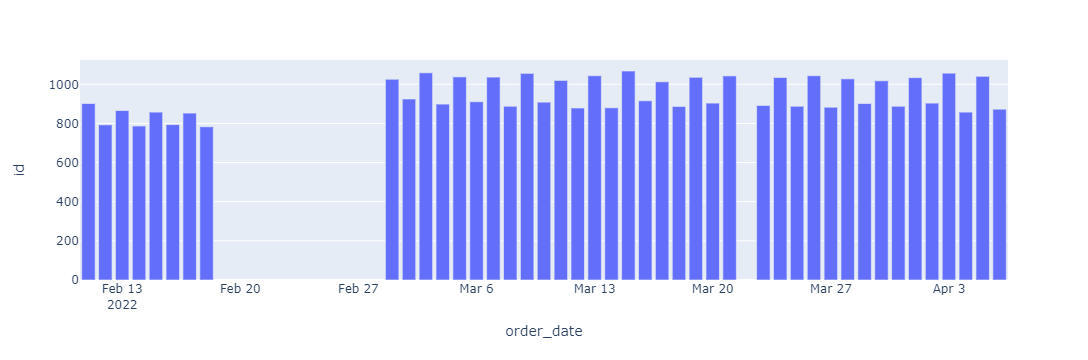

In [100]:
df_aux = df1.loc[:, ['id', 'order_date']].groupby(['order_date']).count().reset_index()

px.bar(df_aux, x='order_date', y='id')

### 2.2.2 Quantidade de pedidos por semana.

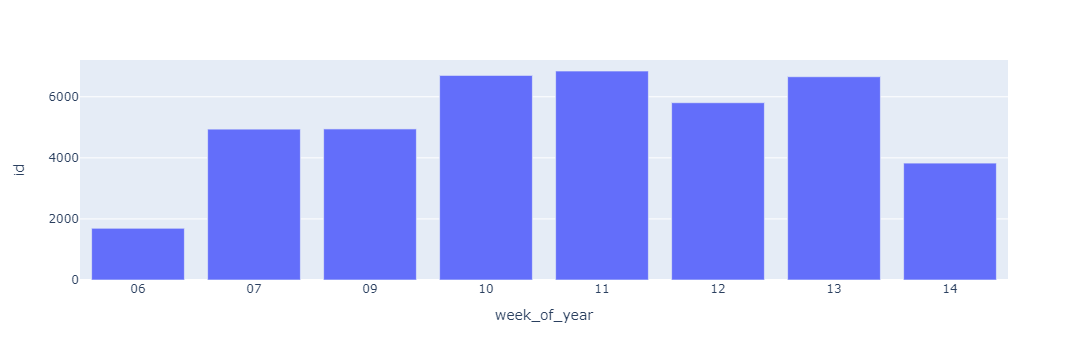

In [102]:
df1['week_of_year'] = df1['order_date'].dt.strftime( "%U" )
df_aux = df1.loc[:, ['id', 'week_of_year']].groupby( 'week_of_year' ).count().reset_index()

px.bar( df_aux, x='week_of_year', y='id' )

### 2.2.3 Distribuição dos pedidos por tipo de tráfego.

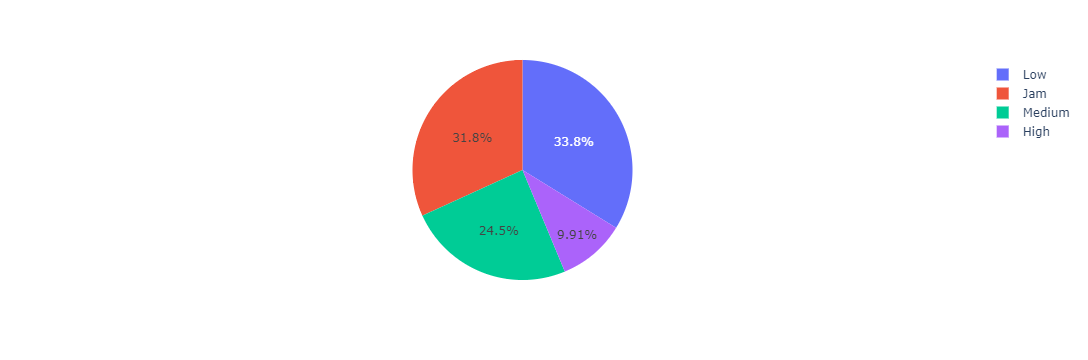

In [103]:
df_aux = df1.loc[:, ['id', 'road_traffic_density']].groupby( 'road_traffic_density' ).count().reset_index()
df_aux['perc_id'] = 100 * ( df_aux['id'] / df_aux['id'].sum() )

# gráfico
px.pie( df_aux, values='perc_id', names='road_traffic_density' )

### 2.2.4 Comparação do volume de pedidos por cidade e tipo de tráfego.

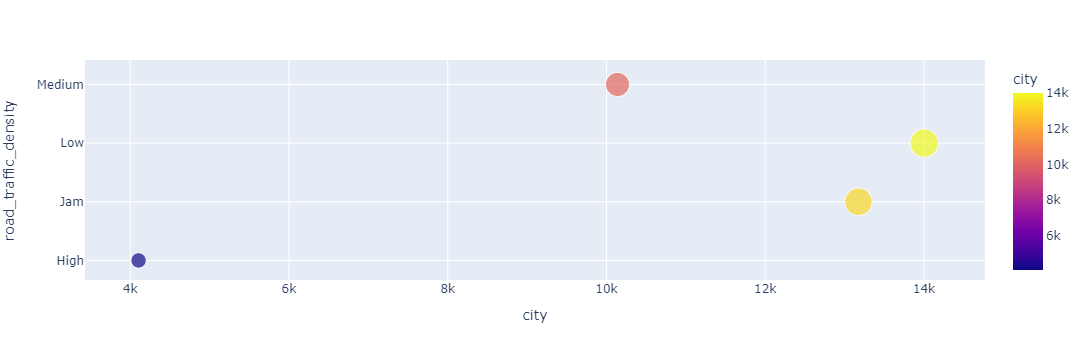

In [104]:
df_aux = df1.loc[:, ['id', 'city','road_traffic_density']].groupby( 'road_traffic_density' ).count().reset_index()
                  
# gráfico
px.scatter( df_aux, x='city', y='road_traffic_density', size='id', color='city' )

### 2.2.5 A quantidade de pedidos por entregador por semana.

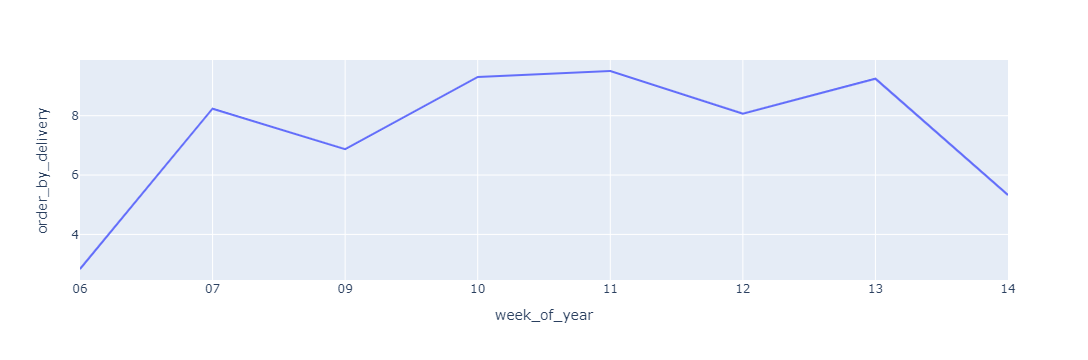

In [105]:
df_aux1 = df1.loc[:, ['id', 'week_of_year']].groupby( 'week_of_year' ).count().reset_index()
df_aux2 = df1.loc[:, ['delivery_person_id', 'week_of_year']].groupby( 'week_of_year').nunique().reset_index()
df_aux = pd.merge( df_aux1, df_aux2, how='inner' )
df_aux['order_by_delivery'] = df_aux['id'] / df_aux['delivery_person_id']
# gráfico
px.line( df_aux, x='week_of_year', y='order_by_delivery' )

### 2.2.6 A localização central de cada cidade por tipo de tráfego.

In [108]:
data_plot = df1.loc[:, ['city', 'road_traffic_density', 'delivery_location_latitude', 'delivery_location_longitude']].groupby( ['city', 'road_traffic_density']).median().reset_index()
data_plot = data_plot[data_plot['city'] != 'NaN']
data_plot = data_plot[data_plot['road_traffic_density'] != 'NaN']
# Desenhar o mapa
map_ = folium.Map( zoom_start=11 )
for index, location_info in data_plot.iterrows():
    folium.Marker( [location_info['delivery_location_latitude'],
        location_info['delivery_location_longitude']],
        popup=location_info[['city', 'road_traffic_density']] ).add_to( map_ )
                                                                                                                                
map_

## 2.3 VISÃO ENTREGADORES

### 2.3.1 A menor e maior idade dos entregadores.

In [109]:
idade_min = df1['delivery_person_age'].min()
idade_max = df1['delivery_person_age'].max()

print('''Idade menor: {}
Idade maior: {}'''.format(idade_min, idade_max))

Idade menor: 20
Idade maior: 39


### 2.3.2 A pior e a melhor condição de veículos.

In [111]:
veiculo_melhor = df1['vehicle_condition'].max()
veiculo_pior = df1['vehicle_condition'].min()

print('''Melhor condição de veículo: {}
Pior condição de veículo: {}'''.format(veiculo_melhor, veiculo_pior))

Melhor condição de veículo: 2
Pior condição de veículo: 0


### 2.3.3 A avaliação médida por entregador.

In [112]:
avaliacao_media = df1.loc[:, ['delivery_person_id', 'delivery_person_ratings']].groupby('delivery_person_id').mean().reset_index()

avaliacao_media

,delivery_person_id,delivery_person_ratings
0,AGRRES010DEL01,4.761538
1,AGRRES010DEL02,4.671429
2,AGRRES010DEL03,4.575000
3,AGRRES01DEL01,4.522222
4,AGRRES01DEL02,4.700000
...,...,...
1315,VADRES19DEL02,4.632727
1316,VADRES19DEL03,4.670270
1317,VADRES20DEL01,4.620370
1318,VADRES20DEL02,4.591111


### 2.3.4 A avaliação média e o desvio padrão por tipo de tráfego.

In [114]:
avaliacao_agg_veiculo = df1.loc[:, ['road_traffic_density', 'delivery_person_ratings']].groupby('road_traffic_density').agg({'delivery_person_ratings' : ('mean', 'std')})
avaliacao_agg_veiculo.columns = ['delivery_mean', 'delivery_std']

avaliacao_agg_veiculo.reset_index() 

,road_traffic_density,delivery_mean,delivery_std
0,High,4.652230,0.273044
1,Jam,4.594019,0.329778
2,Low,4.645011,0.338080
3,Medium,4.660138,0.274245


### 2.3.5 A avaliação média e o desvio padrão por condições climáticas.

In [116]:
avaliacao_agg_clima = df1.loc[:, ['weatherconditions', 'delivery_person_ratings']].groupby('weatherconditions').agg({'delivery_person_ratings' : ('mean', 'std')})
avaliacao_agg_clima.columns = ['delivery_mean', 'delivery_std']

avaliacao_agg_clima.reset_index()

,weatherconditions,delivery_mean,delivery_std
0,conditions Cloudy,4.651871,0.281197
1,conditions Fog,4.652965,0.275060
2,conditions Sandstorms,4.611748,0.310852
3,conditions Stormy,4.611819,0.313096
4,conditions Sunny,4.654868,0.396674
5,conditions Windy,4.616128,0.304565


### 2.3.6 Os 10 entregadores mais rápidos por cidade.

In [118]:
df2 = df1.loc[:, ['delivery_person_id', 'city', 'time_taken(min)']].groupby(['city', 'delivery_person_id']).min().sort_values(['city','time_taken(min)']).reset_index()
df_aux01 = df2.loc[df2['city'] == 'Metropolitian', :].head(10)
df_aux02 = df2.loc[df2['city'] == 'Urban', :].head(10)
df_aux03 = df2.loc[df2['city'] == 'Semi-Urban', :].head(10)

df3 = pd.concat([df_aux01, df_aux02, df_aux03]).reset_index()
df3.head(10)

,index,city,delivery_person_id,time_taken(min)
0,0,Metropolitian,AGRRES010DEL03,10
1,1,Metropolitian,AGRRES07DEL03,10
2,2,Metropolitian,AGRRES12DEL01,10
3,3,Metropolitian,AGRRES14DEL01,10
4,4,Metropolitian,AGRRES17DEL03,10
5,5,Metropolitian,ALHRES08DEL03,10
6,6,Metropolitian,ALHRES12DEL01,10
7,7,Metropolitian,ALHRES14DEL02,10
8,8,Metropolitian,ALHRES15DEL02,10
9,9,Metropolitian,ALHRES19DEL03,10


### 2.3.7 Os 10 entregadores mais lentos por cidade.

In [119]:
df2 = df1.loc[:, ['delivery_person_id', 'city', 'time_taken(min)']].groupby(['city', 'delivery_person_id']).max().sort_values(['city','time_taken(min)']).reset_index()
df_aux01 = df2.loc[df2['city'] == 'Metropolitian', :].head(10)
df_aux02 = df2.loc[df2['city'] == 'Urban', :].head(10)
df_aux03 = df2.loc[df2['city'] == 'Semi-Urban', :].head(10)

df3 = pd.concat([df_aux01, df_aux02, df_aux03]).reset_index()
df3.head(10)

,index,city,delivery_person_id,time_taken(min)
0,0,Metropolitian,KOCRES16DEL03,22
1,1,Metropolitian,ALHRES02DEL02,23
2,2,Metropolitian,KNPRES03DEL02,23
3,3,Metropolitian,KOLRES01DEL03,24
4,4,Metropolitian,KOCRES02DEL02,25
5,5,Metropolitian,GOARES010DEL02,27
6,6,Metropolitian,KNPRES01DEL01,27
7,7,Metropolitian,KOCRES02DEL03,27
8,8,Metropolitian,AURGRES08DEL03,28
9,9,Metropolitian,BHPRES19DEL03,28


## 2.4 VISÃO RESTAURANTES

### 2.4.1 A quantidade de entregadores únicos.

In [124]:
len(df1['delivery_person_id'].unique())

1320

### 2.4.2 A distância média dos resturantes e dos locais de entrega.

In [129]:
cols = ['restaurant_latitude', 'restaurant_longitude', 'delivery_location_latitude', 'delivery_location_longitude']

df1['distance'] = df1.loc[0:10, cols].apply( lambda x:
                              haversine(
                                  (x['restaurant_latitude'], x['restaurant_longitude']), 
                                  (x['delivery_location_latitude'], x['delivery_location_longitude'])), axis=1)

distancia_media = df1.loc[:, 'distance'].mean()

print('A distância média dos restaurantes com os locais de entrega é de ' + str(distancia_media))

A distância média dos restaurantes com os locais de entrega é de 10.606957967616198


### 2.4.3 O tempo médio e o desvio padrão de entrega por cidade.

In [130]:
cols = ['time_taken(min)', 'city']

df_aux = df1.loc[:, cols].groupby('city').agg({'time_taken(min)' : ['mean', 'std']})
df_aux.columns = ['media_time', 'desvio_time']

df_aux.reset_index()

,city,media_time,desvio_time
0,Metropolitian,27.428083,9.133374
1,Semi-Urban,49.710526,2.724992
2,Urban,23.209379,8.858049


### 2.4.4 O tempo médio e o desvio padrão de entrega por cidade e tipo de pedido.

In [131]:
cols = ['time_taken(min)', 'city', 'type_of_order']

df_aux = df1.loc[:, cols].groupby(['city', 'type_of_order']).agg({'time_taken(min)' : ['mean', 'std']})
df_aux.columns = ['media_time', 'desvio_time']

df_aux.reset_index()

,city,type_of_order,media_time,desvio_time
0,Metropolitian,Buffet,27.299008,9.153107
1,Metropolitian,Drinks,27.322691,9.041655
2,Metropolitian,Meal,27.616383,9.214536
3,Metropolitian,Snack,27.468414,9.119676
4,Semi-Urban,Buffet,49.707317,2.731702
5,Semi-Urban,Drinks,49.625000,2.459347
6,Semi-Urban,Meal,50.300000,3.041665
7,Semi-Urban,Snack,49.408163,2.707385
8,Urban,Buffet,23.560652,9.056348
9,Urban,Drinks,23.311977,8.927314


### 2.4.5 O tempo médio e o desvio padrão de entrega por cidade e tipo de tráfego.

In [132]:
cols = ['time_taken(min)', 'city', 'road_traffic_density']

df_aux = df1.loc[:, cols].groupby(['city', 'road_traffic_density']).agg({'time_taken(min)' : ['mean', 'std']})
df_aux.columns = ['media_time', 'desvio_time']

df_aux.reset_index()

,city,road_traffic_density,media_time,desvio_time
0,Metropolitian,High,28.140898,7.904645
1,Metropolitian,Jam,31.976991,9.476203
2,Metropolitian,Low,22.257675,6.794772
3,Metropolitian,Medium,27.729966,8.308064
4,Semi-Urban,High,50.125000,2.629956
5,Semi-Urban,Jam,49.841270,2.717095
6,Semi-Urban,Medium,47.400000,2.011080
7,Urban,High,24.305335,8.494842
8,Urban,Jam,27.993164,10.078271
9,Urban,Low,19.446809,6.319963


### 2.4.6 O tempo médio de entrega durantes os Festivais.

In [133]:
cols = ['time_taken(min)', 'festival']

df_aux = df1.loc[:, cols].groupby(['festival']).agg({'time_taken(min)' : ['mean', 'std']})
df_aux.columns = ['media_time', 'desvio_time']
df_aux = df_aux.reset_index()

linhas_selecionadas = df_aux['festival'] == 'Yes'
df_aux = df_aux.loc[linhas_selecionadas, :]

df_aux

,festival,media_time,desvio_time
1,Yes,45.518607,4.005399
